In [553]:
#Import libraries
import pandas as pd
import numpy as np
from itertools import product
import xgboost as xgb
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_curve, auc, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import torch
import torch.nn.functional as F
from torch import nn, optim

%matplotlib inline

In [546]:
#Funciones auxiliares
def rellenar_combinaciones(dataFrame):
    #Rellenar las combinaciones en todos los años y meses sin ventas con zeros
    print("Rellenado combinaciones")
    now = datetime.now()
    hora = now.strftime("%H:%M:%S")
    print("Hora Inicio {}".format(hora))
    
    dataFrameCopy = dataFrame.copy()
    dataFrame = dataFrame.groupby(["Fecha", "Cliente", "MarcaCombinada"])["Volumen", "disc", "nr"].sum().reset_index()
    Periods = list(dataFrame[["Fecha"]].drop_duplicates().itertuples(index=False))
    Combinations = list(dataFrame[["Cliente", "MarcaCombinada"]].drop_duplicates().itertuples(index=False))
    allCombinations = [(Periods.Fecha, Combinations.Cliente, Combinations.MarcaCombinada) for Periods, Combinations in product(Periods, Combinations)]
    dataFrame = dataFrame.set_index(["Fecha", "Cliente", "MarcaCombinada"]).reindex(allCombinations, fill_value=0).reset_index()

    #Agregar el resto de variables a partir de la marca combinada 
    listaColumnas = ["MarcaCombinada", "SegmentoPrecio2", "Marca2", "Cupo2", "CapacidadEnvase2"]
    agregarColumnas = dataFrameCopy.loc[:, listaColumnas].drop_duplicates()
    dataFrame = dataFrame.merge(agregarColumnas, how='left', on=['MarcaCombinada'], validate="m:1")
    
    return dataFrame


def agregar_horizonte_prediccion(dataFrame, fechaPredecir):
    print("Agregando horizonte predicción")
    now = datetime.now()
    hora = now.strftime("%H:%M:%S")
    print("Hora Inicio {}".format(hora))
    
    dataFrameCopy = dataFrame.copy()
    horizonte = dataFrame.loc[:, ["MarcaCombinada", "Cliente"]].drop_duplicates()
    horizonte['Fecha'] = fechaPredecir

    #Agregar el resto de variables a partir de la marca combinada 
    listaColumnas = ["MarcaCombinada", "SegmentoPrecio2", "Marca2", "Cupo2", "CapacidadEnvase2"]
    agregarColumnas = dataFrameCopy.loc[:, listaColumnas].drop_duplicates()
    horizonte = horizonte.merge(agregarColumnas, how='left', on=['MarcaCombinada'], validate="m:1")

    horizonte = horizonte.reindex(columns = [column for column in dataFrame.columns])
    horizonte.fillna(0, inplace=True)
    dataFrame = pd.concat([dataFrame, horizonte], axis = 0)
    
    return dataFrame


def featuresTotales(dataFrame, dataFrame2, listaFeaturesTotal):
    print("Creando features totales")
    now = datetime.now()
    hora = now.strftime("%H:%M:%S")
    print("Hora Inicio {}".format(hora))
    
    for feature in featuresTotal:
        tempdf = dataFrame2.groupby(["Fecha", "Cliente"])["{}".format(feature)].sum().reset_index().rename(columns={"{}".format(feature):"{}Total".format(feature)})
        dataFrame = dataFrame.merge(tempdf, on=["Fecha", "Cliente"], 
                                    how='left', validate="m:1")

    dataFrame.fillna(0, inplace=True)
    
    return dataFrame


def featuresPorMarca(dataFrame, dataFrame2, listaFeaturesTotal):
    print("Creando features por marcas")
    now = datetime.now()
    hora = now.strftime("%H:%M:%S")
    print("Hora Inicio {}".format(hora))

    for marca in marcasTotal:
        for feature in featuresTotal:
            tempdf = dataFrame2.loc[dataFrame2.Marca2 == marca, :]
            tempdf = Venta.groupby(["Fecha", "Cliente"])["{}".format(feature)].sum().reset_index().rename(columns={"{}".format(feature):"{}{}".format(feature, marca)})
            dataFrame = dataFrame.merge(tempdf, on=["Fecha", "Cliente"], 
                                        how='left', validate="m:1")

            dataFrame.fillna(0, inplace=True)
    
    return dataFrame


def crear_features(dataFrame, featureList, functionsList, lagList, aggregationList):
    print("Agregando y laggueando features creadas")
    now = datetime.now()
    hora = now.strftime("%H:%M:%S")
    print("Hora Inicio {}".format(hora))

    if "mean" in functionsList:
        for variable in featureList:
            for aggregation in aggregationList:
                for lag in lagList:
                    dataFrameGrouped = dataFrame.groupby(["Cliente", "MarcaCombinada"])[variable].rolling(aggregation).sum().reset_index().set_index("level_2").sort_index()
                    dataFrameGrouped = dataFrameGrouped.groupby(["Cliente", "MarcaCombinada"]).shift(lag)
                    dataFrame.insert(len(dataFrame.columns), "Lag_{}_Mean_{}_months_{}".format(lag, aggregation, variable), dataFrameGrouped)

    if "lag" in functionsList:
        for variable in featureList:
            for lag in lagList:
                dataFrameGrouped = dataFrame.groupby(["Cliente", "MarcaCombinada"])[variable].shift(lag)
                dataFrame.insert(len(dataFrame.columns), "Lag_{}_{}".format(lag, variable), dataFrameGrouped)


    dataFrame = dataFrame.loc[~dataFrame["Lag_{}_Mean_{}_months_Volumen".format(max(lagList), max(aggregationList))].isna(), :]  
    
    return dataFrame


def generate_cluster(dataFrame, number_clusters, featuresCluster, fechaCluster):
    print("Creando el cluster")
    now = datetime.now()
    hora = now.strftime("%H:%M:%S")
    print("Hora Inicio {}".format(hora))

    dataFrameCopy = dataFrame.copy(deep=True)
    dataFrameCopy = dataFrameCopy.loc[dataFrameCopy.Fecha >= fechaCluster]
    dataFrameCopy = dataFrameCopy.loc[dataFrameCopy.Fecha != '2020/10/01']
    dataFrameGrouped = dataFrameCopy.groupby(['Cliente', 'MarcaCombinada'])[[x for x in featuresCluster]].sum().reset_index()
    
    scaler_train = MinMaxScaler()

    clusterModel = KMeans(n_clusters = number_clusters, n_jobs=-1)
    clusterModel.fit(scaler_train.fit_transform(dataFrameGrouped.loc[:, [x for x in featuresCluster]]))
    clustersLabels = clusterModel.labels_
    dataFrameGrouped.insert(len(dataFrameGrouped.columns), "Cluster", clustersLabels)
    dataFrame = dataFrame.merge(dataFrameGrouped.loc[:, ['Cliente', 'MarcaCombinada', "Cluster"]], how='left', on=['Cliente', 'MarcaCombinada'], validate="m:1")
    return dataFrame


def train_test_val_split(dataFrame, testSetSD='2020/09/01', testSetED='2020/09/01'):
    print("Creando Train, Test y Pred sets")
    now = datetime.now()
    hora = now.strftime("%H:%M:%S")
    print("Hora Inicio {}".format(hora))
    
    columnasLeak = ['Volumen', 'disc', 'nr', 'Frecuencia', 
                   'FrecuenciaTotal', 'VolumenTotal', 'discTotal', 'nrTotal',
                   'FrecuenciaMarca_20', 'VolumenMarca_20', 'discMarca_20', 'nrMarca_20',
                   'FrecuenciaMarca_16', 'VolumenMarca_16', 'discMarca_16', 'nrMarca_16',
                   'FrecuenciaMarca_9', 'VolumenMarca_9', 'discMarca_9', 'nrMarca_9',
                   'FrecuenciaMarca_38', 'VolumenMarca_38', 'discMarca_38', 'nrMarca_38',
                   'FrecuenciaMarca_39', 'VolumenMarca_39', 'discMarca_39', 'nrMarca_39']
    
    X_test = dataFrame.loc[(dataFrame["Fecha"] >= testSetSD) & 
                           (dataFrame["Fecha"] <= testSetED), 
                            [column for column in dataFrame.columns if column not in columnasLeak]]
    y_test = dataFrame.loc[(dataFrame["Fecha"] >= testSetSD) & 
                           (dataFrame["Fecha"] <= testSetED), 
                             'Volumen']

    X_pred = dataFrame.loc[(dataFrame["Fecha"] >= '2020/10/01'), 
                            [column for column in dataFrame.columns if column not in columnasLeak]]
    
    X_train = dataFrame.loc[(dataFrame["Fecha"] >= '2020/07/01') & 
                            (dataFrame["Fecha"] <= '2020/08/01'), 
                             [column for column in dataFrame.columns if column not in columnasLeak]]
    y_train = dataFrame.loc[(dataFrame["Fecha"] >= '2020/07/01') & 
                            (dataFrame["Fecha"] <= '2020/08/01'), 
                             'Volumen']

    return X_train, y_train, X_test, y_test, X_pred


In [547]:
#Import datasets
Estructura = pd.read_csv("Input1_clientes_estructura.csv", sep=";")
Venta = pd.read_csv("Input2_clientes_venta.csv", sep=";")
Test = pd.read_csv("Input3_clientes_test.csv", sep=";")

#Crear tabla equivalencias
marcasEquivalentes = pd.DataFrame(columns = ["Marca2", "Cupo2", "CapacidadEnvase2", "MarcaCombinada"])
marcasEquivalentes.loc[0] = ["Marca_20", "Cupo_3", "CapacidadEnvase_9", "Marca1"]
marcasEquivalentes.loc[1] = ["Marca_16", "Cupo_2", "CapacidadEnvase_10", "Marca2"]
marcasEquivalentes.loc[2] = ["Marca_9", "Cupo_3", "CapacidadEnvase_12", "Marca3"]
marcasEquivalentes.loc[3] = ["Marca_38", "Cupo_2", "CapacidadEnvase_10", "Marca_Inno1"]
marcasEquivalentes.loc[4] = ["Marca_39", "Cupo_2", "CapacidadEnvase_10", "Marca_Inno2"]

#Quitar los volumenes 0
Venta = Venta.loc[Venta.Volumen > 0, :]

#Left join la marca equivalente a la tabla de ventas para tener la marcas objetivo
Venta = pd.merge(Venta, marcasEquivalentes, 
                 on = ["Marca2", "Cupo2", "CapacidadEnvase2"], 
                 how='left',
                 validate="m:1")

#Cambiar Año/Mes por fecha
Venta['Fecha'] = pd.to_datetime(Venta['Año'].astype(str) + '/' + Venta.Mes.astype(str) + '/01', format='%Y/%m/%d')

#Filtrar solo las Marcas solicitadas
portafolioVenta = Venta.loc[~(Venta.MarcaCombinada.isna()), :]

#Crear frecuencia dataSet original
Venta['Frecuencia'] = np.where(Venta["Volumen"] != 0, 1, 0)

#Rellenar las combinaciones en todos los años y meses con ceros dataSet objetivo
portafolioVenta = rellenar_combinaciones(portafolioVenta)

#Agregar horizonte de prediccion dataSet objetivo
portafolioVenta = agregar_horizonte_prediccion(portafolioVenta, fechaPredecir = pd.to_datetime('2020/10/01', format='%Y/%m/%d'))

#Left join a la estructura
portafolioVenta = pd.merge(portafolioVenta, Estructura, 
                             on = ["Cliente"], 
                             how='left',
                             validate="m:1")

#Crear frecuencia dataSet objetivo
portafolioVenta["Frecuencia"] = np.where(portafolioVenta["Volumen"] != 0, 1, 0)

#Quitar las combinaciones Cliente Marca sin ventas en los ultimos 3 meses
VentasUltimos3Meses = portafolioVenta.loc[portafolioVenta.Fecha >= '2020/07/01', :].groupby(['Cliente', 'MarcaCombinada'])['Frecuencia'].sum().reset_index().rename(columns={'Frecuencia':'VentasUltimos3Meses'})
portafolioVenta = portafolioVenta.merge(VentasUltimos3Meses, on=["Cliente", "MarcaCombinada"], 
                                        how='left', validate="m:1")
portafolioVenta = portafolioVenta.loc[portafolioVenta.VentasUltimos3Meses > 0, :]

#Crear features para totales marcas compradas por clientes
listaFeaturesTotal = ["Frecuencia", "Volumen", "disc", "nr"]
portafolioVenta = featuresTotales(portafolioVenta, Venta, listaFeaturesTotal)

#Crear features para totales marcas compradas por clientes de marcas objetivo
listaFeaturesTotal = ["Frecuencia", "Volumen", "disc", "nr"]
marcasTotal = ["Marca_20", "Marca_16", "Marca_9", "Marca_38", "Marca_39"]
portafolioVenta = featuresPorMarca(portafolioVenta, Venta, listaFeaturesTotal)


#Crear lags y agregaciones de ventas, descuentos, revenue, frecuencia, features totales y features por marca
featureList = ["Volumen", "disc", "nr", 'Frecuencia',
               'FrecuenciaTotal', 'VolumenTotal', 'discTotal', 'nrTotal',
               'FrecuenciaMarca_20', 'VolumenMarca_20', 'discMarca_20', 'nrMarca_20',
               'FrecuenciaMarca_16', 'VolumenMarca_16', 'discMarca_16', 'nrMarca_16',
               'FrecuenciaMarca_9', 'VolumenMarca_9', 'discMarca_9', 'nrMarca_9',
               'FrecuenciaMarca_38', 'VolumenMarca_38', 'discMarca_38', 'nrMarca_38',
               'FrecuenciaMarca_39', 'VolumenMarca_39', 'discMarca_39', 'nrMarca_39']

functionsList = ["mean", "lag"]
lagList = [1, 2, 3]
aggregationList = [2, 3]

portafolioVenta = crear_features(portafolioVenta, featureList, functionsList, lagList, aggregationList)

#Clusters de los clientes para segmentar modelos / utilizar como features
number_clusters=3
featuresCluster = []
featuresCluster.extend([col for col in portafolioVenta.columns if "Frecuencia" in col])
featuresCluster.extend(['Frecuencia'])
portafolioVenta = generate_cluster(portafolioVenta, number_clusters, featuresCluster, fechaCluster='2020/07/01')

Rellenado combinaciones
Hora Inicio 10:36:59
Agregando horizonte predicción
Hora Inicio 10:37:03
Creando features totales
Hora Inicio 10:37:04
Creando features por marcas
Hora Inicio 10:37:05
Agregando y laggueando features creadas
Hora Inicio 10:37:18
Creando el cluster
Hora Inicio 10:55:32


In [548]:
#Dividir la data en train/test
testSetSD  = '2020/09/01'
testSetED = '2020/09/01'

X_train, y_train, X_test, y_test, X_pred = train_test_val_split(portafolioVenta, testSetSD, testSetED)

columnasDummies = ['Categoria', 'SegmentoPrecio2', 'Marca2', 'Cupo2', 'CapacidadEnvase2', 'Regional2', 'Gerencia2', 'SubCanal2']
X_train = pd.get_dummies(X_train, columns=columnasDummies)
X_test = pd.get_dummies(X_test, columns=columnasDummies)
X_pred = pd.get_dummies(X_pred, columns=columnasDummies)

Creando Train, Test y Pred sets
Hora Inicio 10:55:40


In [549]:
#Generar modelos de XGBoost y tunear los hyperparametros.
#Se intentó hacer modelos por Marcas, por Clusters y de toda la data. El mejor AUC (aunque marginal) fue por marcas
#Se intentó scaling los features (aunque para arboles no es necesario). El resultado fue el mismo. 

Results_Xgboost = []
finalResult = pd.DataFrame(columns=['Cliente', 'MarcaCombinada', 'Probabilidad'])
columnasQuitar = ['Fecha','Cliente','MarcaCombinada']

# En caso de que se desee scale los datos
# scaler_train = MinMaxScaler()
# scaler_train.fit(X_train.loc[:, ~(X_train.columns.isin(columnasQuitar))])

for marca in X_train.MarcaCombinada.unique():
    print("Trabajando en: {}".format(marca))
    now = datetime.now()
    hora = now.strftime("%H:%M:%S")
    print("Hora Inicio {}".format(hora))

    #Nested loop para revisar los hyperparametros optimos
    #Se intento con hasta 4000 combinaciones y el gain no es significativo vs el tiempo de entrenamiento
    for n_estimators in [100]:
        for max_depth in [5, 10]:
            for eta in [0.01, 0.001]:
                for alpha in [0, 0.5]:
                    for colsample_bytree in [0.5, 0.8]:
                        for min_child_weight in [5, 12]:
                            for subsample in [0.5, 0.8]:

                                xg_log = xgb.XGBClassifier(objective ='binary:logistic', 
                                                           tree_method = 'gpu_hist', 
                                                           n_jobs=-1,
                                                           n_estimators=n_estimators, 
                                                           max_depth=max_depth, 
                                                           eta=eta,
                                                           alpha=alpha,
                                                           colsample_bytree=colsample_bytree,
                                                           min_child_weight=min_child_weight,
                                                           subsample=subsample,
                                                           seed=42
                                                           )

                                X_trainMod = X_train.loc[X_train.MarcaCombinada == marca, 
                                                         ~(X_train.columns.isin(columnasQuitar))]

                                y_trainMod = y_train[X_train.loc[X_train.MarcaCombinada == marca, 
                                                                ~(X_train.columns.isin(columnasQuitar))].index]

                                xg_log_model = xg_log.fit(X_trainMod, 
                                                          np.where(y_trainMod != 0, 1, 0))

                                X_testMod = X_test.loc[X_test.MarcaCombinada == marca, 
                                                       ~(X_test.columns.isin(columnasQuitar))]

                                y_testMod = y_test[X_test.loc[X_test.MarcaCombinada == marca, 
                                                             ~(X_test.columns.isin(columnasQuitar))].index]

                                score = xg_log_model.score(X_testMod, np.where(y_testMod != 0, 1, 0))

                                y_pred = xg_log_model.predict(X_testMod)

                                fpr, tpr, _ = roc_curve(np.where(y_testMod != 0, 1, 0), y_pred)
                                roc_auc = auc(fpr, tpr)
                                F1Score = f1_score(np.where(y_testMod != 0, 1, 0), y_pred)

                                Results_Xgboost.append([n_estimators, max_depth, eta, alpha, colsample_bytree, min_child_weight, subsample, score, roc_auc, F1Score, marca])

    #Despues del correr todos los modelos, se busca el que mejor tenga AUC, se entrena y se hace la prediccion
    Results_temp = pd.DataFrame(Results_Xgboost, columns = ['n_estimators', 'max_depth', 'eta', 'alpha', 'colsample_bytree', 'min_child_weight', 'subsample', 'score', 'roc_auc', 'F1Score', 'Marca'])
    bestModel = Results_temp.loc[(Results_temp.Marca == marca), :]
    bestModel = bestModel.sort_values(by = "roc_auc", ascending = False).head(1)

    xg_log = xgb.XGBClassifier(objective ='binary:logistic', 
                               tree_method = 'gpu_hist', 
                               n_jobs=-1,
                               n_estimators=bestModel['n_estimators'].to_numpy()[0], 
                               max_depth=bestModel['max_depth'].to_numpy()[0], 
                               eta=bestModel['eta'].to_numpy()[0],
                               alpha=bestModel['alpha'].to_numpy()[0],
                               colsample_bytree=bestModel['colsample_bytree'].to_numpy()[0],
                               min_child_weight=bestModel['min_child_weight'].to_numpy()[0],
                               subsample=bestModel['subsample'].to_numpy()[0],
                               seed=42)

    xg_log_model = xg_log.fit(X_trainMod, 
                              np.where(y_trainMod != 0, 1, 0))

    X_predMod = X_pred.loc[X_pred.MarcaCombinada == marca, 
                           ~(X_pred.columns.isin(columnasQuitar))]

    y_pred = xg_log_model.predict_proba(X_predMod)[:, 1]

    temp = X_pred.loc[X_pred.loc[X_pred.MarcaCombinada == marca, 
                                ~(X_pred.columns.isin(columnasQuitar))].index].loc[:, ['Cliente', 'MarcaCombinada']]

    temp.insert(len(temp.columns), 'Probabilidad', y_pred)

    finalResult = pd.concat([finalResult, temp], axis=0)

    print("Modelo Finalizado, mejor Test AUC fue: {}".format(bestModel['roc_auc'].to_numpy()[0]))

Trabajando en: Marca3
Hora Inicio 10:55:41
Modelo Finalizado, mejor Test AUC fue: 0.6815686074474588
Trabajando en: Marca2
Hora Inicio 10:58:25
Modelo Finalizado, mejor Test AUC fue: 0.5597041847041847
Trabajando en: Marca1
Hora Inicio 10:59:38
Modelo Finalizado, mejor Test AUC fue: 0.7491402174921384
Trabajando en: Marca_Inno1
Hora Inicio 11:02:04
Modelo Finalizado, mejor Test AUC fue: 0.7631888803547917
Trabajando en: Marca_Inno2
Hora Inicio 11:04:31
Modelo Finalizado, mejor Test AUC fue: 0.720465165207428


In [566]:
#Crear una red neuronal
#Con un learning rate de 0.001, el test loss se minimiza entre los 300 - 600 epochs

np.random.seed(42)
torch.manual_seed(42)

X_train_NN = X_train.loc[:, ~(X_train.columns.isin(columnasQuitar))]
X_test_NN = X_test.loc[:, ~(X_test.columns.isin(columnasQuitar))]
X_pred_NN = X_pred.loc[:, ~(X_pred.columns.isin(columnasQuitar))]

torch.cuda.empty_cache()
device = torch.device('cuda')

#Pasos adicionales para Train, Test y Pred(Tensores con dimensiones especificas)
scaler_train = MinMaxScaler()
scaler_train.fit(X_train_NN)

X_train_NN = pd.DataFrame(scaler_train.transform(X_train_NN))
X_train_NN = np.expand_dims(X_train_NN, axis = 0)
X_train_NN = torch.from_numpy(np.array(X_train_NN))
X_train_NN.to(device)

X_test_NN = pd.DataFrame(scaler_train.transform(X_test_NN))
X_test_NN = np.expand_dims(X_test_NN, axis = 0)
X_test_NN = torch.from_numpy(np.array(X_test_NN))
X_test_NN.to(device)

y_train_NN = y_train.copy()
y_train_NN[y_train_NN != 0] = 1
y_train_NN = np.expand_dims(y_train_NN, axis = 0)
y_train_NN = np.expand_dims(y_train_NN, axis = 2)
y_train_NN = torch.from_numpy(np.array(y_train_NN))
y_train_NN.to(device)

y_test_NN = y_test.copy()
y_test_NN[y_test_NN != 0] = 1
y_test_NN = np.expand_dims(y_test_NN, axis = 0)
y_test_NN = np.expand_dims(y_test_NN, axis = 2)
y_test_NN = torch.from_numpy(np.array(y_test_NN))
y_test_NN.to(device)

X_pred_NN = pd.DataFrame(scaler_train.transform(X_pred_NN))
X_pred_NN = np.expand_dims(X_pred_NN, axis = 0)
X_pred_NN = torch.from_numpy(np.array(X_pred_NN))
X_pred_NN.to(device)

#Definir la estructura
class Neural_Network_1(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(X_train_NN.size()[2], 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 1)

        self.dropout = nn.Dropout(p = 0.7)

    def forward(self, x):

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.dropout(x)
        x = torch.sigmoid(self.fc4(x))

        return x

model1 = Neural_Network_1()
model1.to(device)

#Entrenamiento
criterion = nn.BCELoss()
optimizer = optim.Adam(model1.parameters(), lr=0.001)

epochs = 2000
steps = 100
model1.train()

train_losses, test_losses = [], []

Loss_max = 9999999999999999999

for e in range(epochs):

    optimizer.zero_grad()
    output = model1(X_train_NN.to(device).float())
    loss = criterion(output, y_train_NN.to(device).float())
    loss.backward()   
    optimizer.step()

    with torch.no_grad():
        model1.eval()
        output_test = model1(X_test_NN.to(device).float())
        test_loss = criterion(output_test, y_test_NN.to(device).float())

    if (test_loss.item() <= Loss_max):
        torch.save(model1.state_dict(), 'AcesyJazz.pt')
        Loss_max = test_loss.item()
        Epoch_number = e+1

    if (e+1) % steps == 0:
        print("Epoch: {}.. ".format(e+1),
              "Training Loss: {:.3f}.. ".format(loss.item()),
              "Test Loss: {:.3f}.. ".format(test_loss.item()))
    model1.train()

    train_losses.append(loss.item())
    test_losses.append(test_loss.item())

model1 = Neural_Network_1()
model1.to(device)
model1.load_state_dict(torch.load('AcesyJazz.pt'))
model1.eval()

y_pred = model1(X_test_NN.to(device).float())
y_pred = y_pred.cpu().detach().numpy().squeeze()

finalResultNN = X_pred.loc[:, ['Cliente', 'MarcaCombinada']]
finalResultNN.insert(len(finalResultNN.columns), 'Probabilidad', y_pred)

Epoch: 100..  Training Loss: 0.539..  Test Loss: 0.574.. 
Epoch: 200..  Training Loss: 0.500..  Test Loss: 0.512.. 
Epoch: 300..  Training Loss: 0.484..  Test Loss: 0.495.. 
Epoch: 400..  Training Loss: 0.492..  Test Loss: 0.500.. 
Epoch: 500..  Training Loss: 0.477..  Test Loss: 0.509.. 
Epoch: 600..  Training Loss: 0.477..  Test Loss: 0.509.. 
Epoch: 700..  Training Loss: 0.468..  Test Loss: 0.533.. 
Epoch: 800..  Training Loss: 0.470..  Test Loss: 0.520.. 
Epoch: 900..  Training Loss: 0.468..  Test Loss: 0.549.. 
Epoch: 1000..  Training Loss: 0.461..  Test Loss: 0.578.. 
Epoch: 1100..  Training Loss: 0.464..  Test Loss: 0.557.. 
Epoch: 1200..  Training Loss: 0.455..  Test Loss: 0.572.. 
Epoch: 1300..  Training Loss: 0.455..  Test Loss: 0.576.. 
Epoch: 1400..  Training Loss: 0.453..  Test Loss: 0.571.. 
Epoch: 1500..  Training Loss: 0.454..  Test Loss: 0.569.. 
Epoch: 1600..  Training Loss: 0.456..  Test Loss: 0.583.. 
Epoch: 1700..  Training Loss: 0.460..  Test Loss: 0.585.. 
Epoch:

In [579]:
#Organizar las predicciones para que tengan el mismo formato y las mismas keys que el objetivo. 
#En caso de que el modelo no prediga una combinación, se rellena con cero.
#Xgboost dio mejores resultados que la red neuronal densa de 4 capas con dropout. 
TestModified = pd.melt(Test, id_vars=['Cliente'], value_vars=['Marca1' ,'Marca2' ,'Marca3', 'Marca_Inno1', 'Marca_Inno2'])
TestModified.rename(columns={'variable':'MarcaCombinada'}, inplace=True)
TestModified = pd.merge(TestModified, finalResult, on=['Cliente', 'MarcaCombinada'], how='left', validate='1:1')
TestModified.drop(columns='value', inplace=True)
TestModified.fillna(0, inplace=True)
TestModified = TestModified.pivot(index='Cliente', columns='MarcaCombinada', values='Probabilidad').reset_index()
TestModified = TestModified.set_index("Cliente").loc[Test.set_index("Cliente").index].reset_index()
TestModified.to_csv("AcesyJazzFinal.csv", sep=",", index=False)

In [551]:
#Se guardan los resultados del modelo y la metadata de todos los modelos generados para analisis.
finalResult.to_csv("ResultadoFinal.csv")
Results_temp.to_csv("XGBoostModelsFinal.csv")
finalResultNN.to_csv("ResultadoNN.csv")

AUC is : 0.7253526075390252
F1Score is : 0.6351748937561295


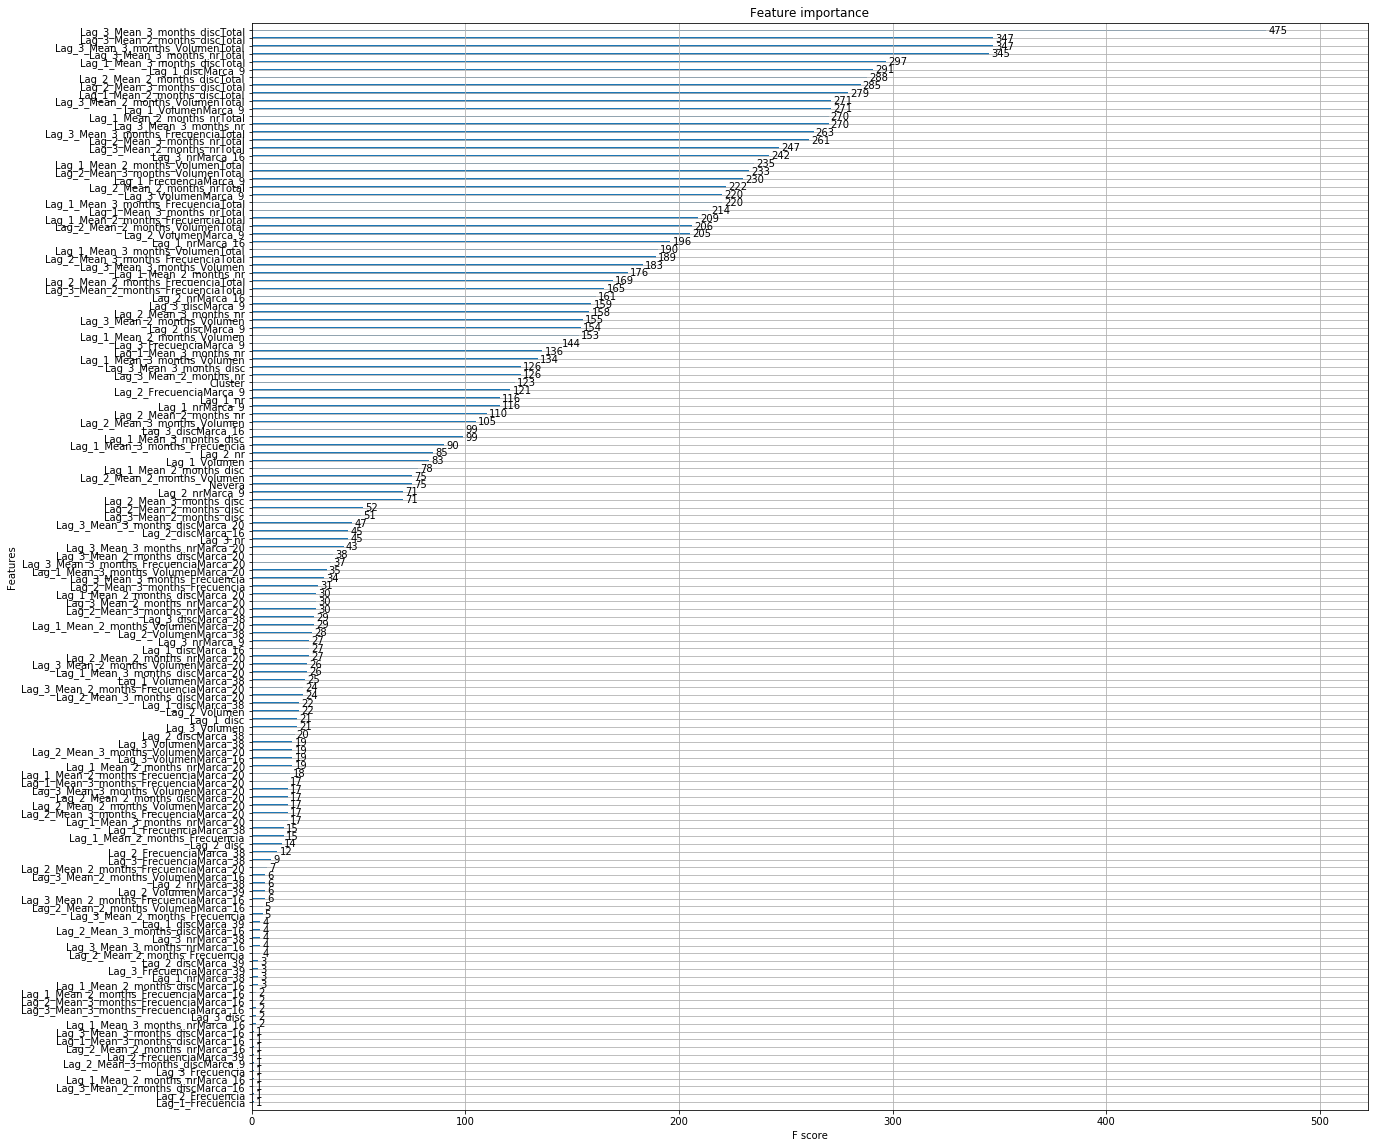

In [522]:
#Revisar el AUC, F1Score y Variable importance del Xgboost variando clusters, productos e hiperparametros
producto='Marca1'
cluster=1

X_trainMod = X_train.loc[X_train.MarcaCombinada == producto, 
                         ~(X_train.columns.isin(columnasQuitar))].drop(columns = columnsExclude)
y_trainMod = y_train[X_trainMod.index]

X_testMod = X_test.loc[X_test.MarcaCombinada == producto , 
                       ~(X_test.columns.isin(columnasQuitar))].drop(columns = columnsExclude)
y_testMod = y_test[X_testMod.index]

n_estimators = 200
max_depth = 12    
eta = 0.01 
alpha = 0.5
colsample_bytree = 0.9
min_child_weight = 10 
subsample = 0.9    

xg_log = xgb.XGBClassifier(objective ='binary:logistic', 
                           tree_method = 'gpu_hist', 
                           n_jobs=-1,
                           n_estimators=n_estimators, 
                           max_depth=max_depth, 
                           eta=eta,
                           alpha=alpha,
                           colsample_bytree=colsample_bytree,
                           min_child_weight=min_child_weight,
                           subsample=subsample,
                           seed=42
                           )


xg_log_model = xg_log.fit(X_trainMod, 
                          np.where(y_trainMod != 0, 1, 0))
                         
score = xg_log_model.score(X_testMod, np.where(y_testMod != 0, 1, 0))

y_pred = xg_log_model.predict(X_testMod)

fpr, tpr, _ = roc_curve(np.where(y_testMod != 0, 1, 0), y_pred)
roc_auc = auc(fpr, tpr)
F1Score = f1_score(np.where(y_testMod != 0, 1, 0), y_pred)

# plot feature importance
print("AUC is : {}".format(roc_auc))
print("F1Score is : {}".format(F1Score))
fig, ax = plt.subplots(figsize=(20, 20))
xgb.plot_importance(xg_log_model, ax=ax)

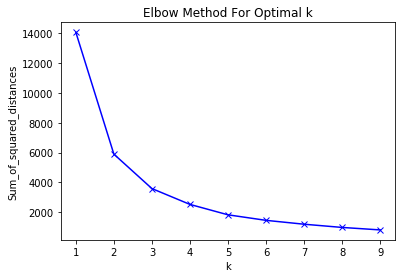

In [394]:
#Analysis para determinar el número optimo de clusters
Sum_of_squared_distances = []
featuresCluster = []
featuresCluster.extend([col for col in X_train.columns if col.startswith("Lag_")])
featuresCluster.extend(['Frecuencia'])

dataFrame = portafolioVenta.copy(deep=True)
dataFrame.drop(columns='Cluster', inplace=True)
dataFrame = dataFrame.loc[dataFrame.Fecha >= '2020/07/01', :]
dataFrame = dataFrame.loc[dataFrame.Fecha != '2020/10/01']
dataFrameGrouped = dataFrame.groupby(['Cliente', 'MarcaCombinada'])[[x for x in featuresCluster]].sum().reset_index()
dataFrameGrouped.columns
scaler_train = MinMaxScaler()

for number_clusters in range(1,10):
  
    clusterModel = KMeans(n_clusters = number_clusters, n_jobs=-1)
    clusterModel.fit(scaler_train.fit_transform(dataFrameGrouped.loc[:, [x for x in featuresCluster]]))
    clustersLabels = clusterModel.labels_
    Sum_of_squared_distances.append(clusterModel.inertia_)

plt.plot(range(1,10), Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()